# tensorflow pistachio
Tuning with hyperopt

## Links
  - [notes on training/validation loss](https://siddiqueabusaleh.medium.com/why-my-training-loss-is-higher-than-validation-loss-is-the-reported-loss-even-accurate-8843e14a0756)
  - [initialisation values](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)
  - [shap feature importance](https://shap.readthedocs.io/en/latest/tabular_examples.html#neural-networks)

In [1]:
import tensorflow as tf
print(tf.__version__)

2024-12-06 13:05:51.719710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1


## arff to csv





In [2]:
import os
os.getcwd()

'/tf/notebooks'

In [3]:
import pandas as pd 
from scipy.io import arff
import os 

from pistachio.data import load_arff_file

label_mapping = {'Kirmizi_Pistachio': 0, 'Siit_Pistachio': 1}


arff_filename = './data/Pistachio_16_Features_Dataset.arff'
csv_filename = './data/pistachio_16.csv'

if not os.path.exists(csv_filename):
    df = load_arff_file(arff_filename, label_mapping)
    df.head()
    df.to_csv(csv_filename, index=False, header=True)
    print(f'wrote file to {csv_filename}')
else:
    print(f'{csv_filename} exists')


./data/pistachio_16.csv exists


In [4]:
## Parameters

In [5]:


# dataset
# BATCH_SIZE = 16 
# PREFETCH = tf.data.AUTOTUNE
SEED=37

# model parameters
# UNITS = 12
# LAYER_1_L1 = 2e-4
# LAYER_1_L2 = 5e-3
# LAYER_2_L1 = 2e-4
# LAYER_2_L2 = 5e-3



#model fitting
# EPOCHS = 500
# LEARNING_RATE = 0.001 # initial learning rate
# LR_PLATEAU_FACTOR = 0.5
# LR_PLATEAU_PATIENCE = 5
# LR_DECAY_RATE = 0.8
# MIN_LEARNING_RATE = 1e-6
# EARLY_STOPPING_PATIENCE = 40


# mlflow
MLFLOW_URI = uri="http://pistachio_mlflow:5000"
MLFLOW_EXPERIMENT = "pistachio_tf_tuning"
MLFLOW_RUN_DESCRIPTION = 'initial tuning of two layer model'
MLFLOW_TAGS = {'architecture': f'two layers'}

# hyperopt
TRIALS_FILE_LOCATION = f'./trials/trials_{MLFLOW_EXPERIMENT}.pkl'
# will save trials object at this location
TRIALS_PER_RUN = 5
# run this many trials per notebook execution.




## dataset


In [6]:
from pistachio.data import read_or_generate_splits

# define where train/test csvs will live
split_data_path = f"./data/seed_{SEED}/"
if not os.path.exists(split_data_path):
    os.makedirs(split_data_path)

train_df, valid_df, test_df = read_or_generate_splits(split_data_path, csv_filename, seed=SEED)

for setname, df in zip(['train','validation','test'],[train_df, valid_df, test_df]):
    print(setname)
    print(f'df shape = {df.shape}')
    agged = df.groupby('Class').agg({'AREA':'count'}).reset_index()
    print(agged)


train
df shape = (1288, 17)
   Class  AREA
0      0   738
1      1   550
validation
df shape = (430, 17)
   Class  AREA
0      0   247
1      1   183
test
df shape = (430, 17)
   Class  AREA
0      0   247
1      1   183


In [7]:
feature_columns = list(train_df.columns)
feature_columns.remove('Class')
feature_columns

['AREA',
 'PERIMETER',
 'MAJOR_AXIS',
 'MINOR_AXIS',
 'ECCENTRICITY',
 'EQDIASQ',
 'SOLIDITY',
 'CONVEX_AREA',
 'EXTENT',
 'ASPECT_RATIO',
 'ROUNDNESS',
 'COMPACTNESS',
 'SHAPEFACTOR_1',
 'SHAPEFACTOR_2',
 'SHAPEFACTOR_3',
 'SHAPEFACTOR_4']

In [8]:
# from pistachio.data import df_to_dataset
# # create datasets
# train_ds = df_to_dataset(train_df,'Class', shuffle=True, drop=True)
# valid_ds = df_to_dataset(valid_df,'Class', shuffle=False, drop=False)
# test_ds = df_to_dataset(test_df,'Class', shuffle=False, drop=False)

In [18]:
from hyperopt import hp
# hyperopt search space/parameters
hp_space = {
    # model
    'units': hp.randint('units', 5,12),
    'layer_l1_reg': hp.loguniform('layer_l1_reg', 2e-6,2e-3),
    'layer_l2_reg':hp.loguniform('layer_l2_reg', 2e-6,2e-3),
    'feature_columns':feature_columns,
    # fitting
    'learning_rate': hp.loguniform('learning_rate', 1e-5,5e-3),
    'lr_plateau_factor': hp.uniform('lr_plateau_factor', 0.5, 0.95),
    'lr_plateau_patience': 20,
    'lr_decay_rate': 0.9,
    'min_learning_rate': 5e-8,
    'early_stopping_patience': 40,

    # data/batch/epochs
    'batch_size': 16,
    'prefetch':  tf.data.AUTOTUNE,
    'epochs': 100,
    'seed':SEED
}


In [19]:
from pistachio.data import df_to_dataset
from pistachio.model import get_pistachio_model
from typing import Dict 
import mlflow
# create datasets
import mlflow
import seaborn as sns
import numpy as np
import pandas as pd
from hyperopt import STATUS_OK

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve

from pistachio.evaluation import plot_metric, get_roc_results, plot_roc_curve, get_confusion_matrix
from pistachio.evaluation import make_precision_recall_plot, make_prob_calibration_plot, make_confusion_matrix_plot
sns.set()



mlflow.set_tracking_uri(uri=MLFLOW_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)

# define our hyperopt objective
def pistachio_objective(params: Dict) -> Dict:
    '''take model parameters, build, train and evaluate model, return loss value and other stats'''
    #     units: int,
    # layer_l1_reg: float,
    # layer_l2_reg: float,
    # feature_columns:feature_columns,
    # learning_rate: float,
    # lr_plateau_factor: float,
    # lr_plateau_patience: int,
    # lr_decay_rate: float,
    # min_learning_rate: float,
    # early_stopping_patience: int,
    # batch_size: int,
    # prefetch:  int,
    # epochs: int,
    # seed:int 
    
    # reset tf state
    tf.keras.backend.clear_session()

    # start mlflow run
    with  mlflow.start_run(tags=MLFLOW_TAGS, description=MLFLOW_RUN_DESCRIPTION) as mlflow_run:

        run_name = mlflow_run.info.run_name
        run_id = mlflow_run.info.run_id
        # mlflow.log_params(kwargs)


        # define datasets 
        # think these need to go in here, given that we're clearing the tf state
        train_ds = df_to_dataset(
            train_df,
            'Class',
            shuffle=True,
            drop=True,
            batch_size=params.get('batch_size'),
            prefetch=params.get('prefetch'))

        valid_ds = df_to_dataset(
            valid_df,
            'Class', 
            shuffle=False,
            drop=False,
            batch_size=params.get('batch_size'),
            prefetch=params.get('prefetch'))
        
        # get the model we'll train, adapting it on train data
        model = get_pistachio_model(
            feature_columns=params.get('feature_columns'),
            train_dataset=train_ds,
            units=params.get('units',10),
            layer_l1_reg=params.get('layer_l1_reg'),
            layer_l2_reg=params.get('layer_l2_reg'))
    
        checkpoint_dir = './pistachio_model_checkpoints/'
        checkpoint_path = os.path.join(checkpoint_dir,f'model_{mlflow_run.info.run_name}.model.keras')

        os.makedirs(checkpoint_dir, exist_ok=True)

        metrics = {
        'predicted_probability': [
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.BinaryAccuracy()]}

        callbacks = [
            # tf.keras.callbacks.TensorBoard(logdir, update_freq='batch'),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=params.get('lr_plateau_factor'), 
                patience=params.get('lr_plateau_patience'), 
                min_lr=params.get('min_learning_rate')),
            tf.keras.callbacks.EarlyStopping(patience=params.get('early_stopping_patience')),
            # checkpoint
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor='val_loss',
                mode='min',
                initial_value_threshold=0.0,
                save_best_only=True),
            # mlflow
            mlflow.keras.MlflowCallback(mlflow_run)]
    
        optimizer = tf.keras.optimizers.Adam(learning_rate=params.get('learning_rate'))

        # compile model
        model.compile(
            optimizer=optimizer,
            loss={'predicted_probability': tf.keras.losses.BinaryCrossentropy(from_logits=False)},
            metrics=metrics)
        
        # train model
        history = model.fit(
            train_ds,
            epochs=params.get('epochs'),
            callbacks=callbacks,
            validation_data=valid_ds,
            verbose=2)
        
        history_df = pd.DataFrame(history.history)
        history_df['epoch'] = history_df.index
        # history_df.columns

        # plot training stuff
        plot_dir = f'./plots/{run_name}/'
        os.makedirs(plot_dir, exist_ok=True)
        metrics_to_plot = [
            'learning_rate',
            'auc',
            'loss',
            'binary_accuracy',
            'recall',
            'precision']

        metric_plots = {}
        for mm in metrics_to_plot:
            metric_plots[mm] = plot_metric(history_df, mm);
            fig_path = os.path.join(plot_dir, f'{mm}_vs_epoch.png');
            print(fig_path)
            metric_plots[mm][0].savefig(fig_path);
        
        # look at the best training epoch, get some metrics

        val_metrics = [k for k in history_df.columns if k.startswith('val')]
        best_epoch = history_df.loc[history_df.val_loss == np.min(history_df.val_loss)][['epoch'] + val_metrics].copy()

        # best_epoch
        rename = {k:f'best_epoch_{k}' for k in val_metrics}
        rename['epoch'] = 'best_epoch'

        best_stats = best_epoch\
            .rename(columns=rename)\
            .to_dict(orient='records')[0]
        
        # log these things
        mlflow.log_artifacts(plot_dir, artifact_path='training_plots')
        mlflow.log_metrics(best_stats)

        # load the best version of the model
        model = tf.keras.models.load_model(checkpoint_path)
        # get predictions on validation set
        valid_features = {k: valid_df[k].values for k in feature_columns}
        valid_predictions = model.predict(valid_features)
        valid_df['predicted_prob'] = valid_predictions
        threshold = 0.5
        valid_df['predicted_class'] = valid_df.predicted_prob.map(lambda x: 0 if x < threshold else 1)

        # roc curve
        roc_results = get_roc_results(valid_df.predicted_prob, valid_df.Class)
        valid_auc_score = roc_auc_score(valid_df.Class, valid_df.predicted_prob)
        fig, ax = plot_roc_curve(*roc_results, title=f'validation data, auc_score = {valid_auc_score}');
        roc_plot_path = os.path.join(plot_dir, 'roc_curve.png')
        fig.savefig(roc_plot_path)

        # precision recall
        fig, ax = make_precision_recall_plot(valid_df.predicted_prob, valid_df.Class, title='precision-recall')
        prec_rec_path = os.path.join(plot_dir,'precision_recall_curve.png')
        fig.savefig(prec_rec_path)

        # confusion matrix
        fig, ax = make_confusion_matrix_plot(valid_df.predicted_class, valid_df.Class)
        confusion_plot_path = os.path.join(plot_dir, 'confusion_matrix.png')
        fig.savefig(confusion_plot_path)

        # prob calibration
        fig, ax = make_prob_calibration_plot(valid_df.predicted_prob, valid_df.Class, title='pistachio classifier probability calibration')
        prob_cal_path = os.path.join(plot_dir,'probability_calibration.png')
        fig.savefig(prob_cal_path)

        validation_metrics_path = './saved_model_validation_metrics.txt'
        with open(validation_metrics_path,'w') as outfile:
            outfile.write(f'accuracy: {accuracy_score(valid_df.Class,valid_df.predicted_class)}\n')
            outfile.write(f'precision: {precision_score(valid_df.Class,valid_df.predicted_class)}\n')
            outfile.write(f'recall: {recall_score(valid_df.Class,valid_df.predicted_class)}\n')
            outfile.write(f'f1_score: {f1_score(valid_df.Class,valid_df.predicted_class)}\n')
            outfile.write(f'roc_auc_score: {valid_auc_score}\n')
        
            mlflow.log_artifact(roc_plot_path, artifact_path='evaluation_plots')
            mlflow.log_artifact(confusion_plot_path, artifact_path='evaluation_plots')
            mlflow.log_artifact(prob_cal_path, artifact_path='evaluation_plots')
            mlflow.log_artifact(prec_rec_path, artifact_path='evaluation_plots')

            mlflow.log_artifact(validation_metrics_path)
            # mlflow.log_artifact(shap_bar_path, artifact_path='evaluation_plots')
            # mlflow.log_artifact(shap_violin_path, artifact_path='evaluation_plots')

        # print(open(validation_metrics_path,'r').read())
        # return. Can put more info in here, but it should be in mlflow regardless
        return {'status': STATUS_OK, 'loss': best_stats['best_epoch_val_loss'], 'true_loss':best_stats['best_epoch_val_loss'] }



preprocessing - initialising normalisers             
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024-12-06 13:20:10.348084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-06 13:20:10.388623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-06 13:20:10.425698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-06 13:20:10.463742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-06 13:20:10.502247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-06 13:20:10.539615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-06 13:20:10.586554: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 1/100                                          

80/80 - 2s - 24ms/step - auc: 0.5042 - binary_accuracy: 0.5445 - loss: 54.4366 - precision: 0.4455 - recall: 0.2532 - val_auc: 0.5000 - val_binary_accuracy: 0.5744 - val_loss: 56.8683 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0042

Epoch 2/100                                          

80/80 - 0s - 1ms/step - auc: 0.4987 - binary_accuracy: 0.5469 - loss: 42.8874 - precision: 0.4524 - recall: 0.2774 - val_auc: 0.5000 - val_binary_accuracy: 0.5744 - val_loss: 60.7640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0042

Epoch 3/100                                          

80/80 - 0s - 2ms/step - auc: 0.4778 - binary_accuracy: 0.5453 - loss: 43.7106 - precision: 0.4375 - recall: 0.2308 - val_auc: 0.5000 - val_binary_accuracy: 0.5744 - val_loss: 60.3178 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0042

Epoch 4/100                                        

job exception: File not found: filepath=./pistachio_model_checkpoints/model_incongruous-newt-36.model.keras. Please ensure the file is an accessible `.keras` zip file.



  0%|          | 0/1 [00:17<?, ?trial/s, best loss=?]


ValueError: File not found: filepath=./pistachio_model_checkpoints/model_incongruous-newt-36.model.keras. Please ensure the file is an accessible `.keras` zip file.

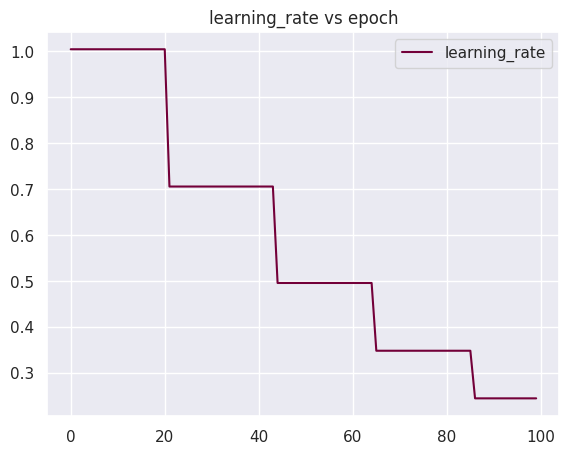

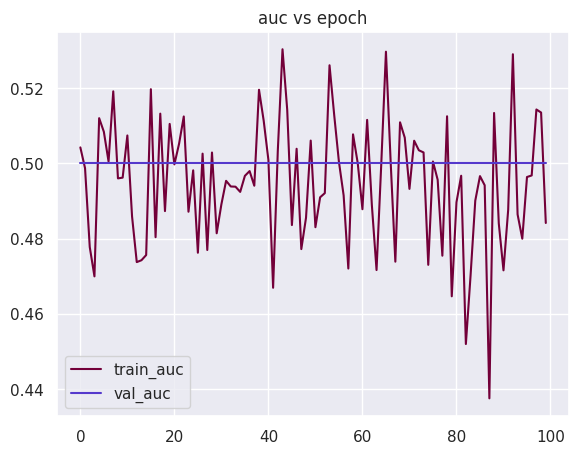

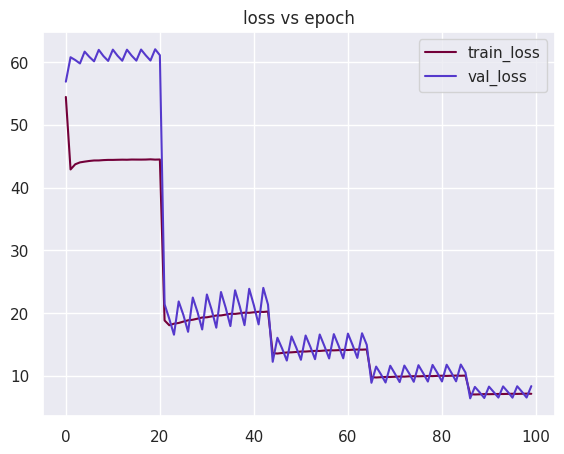

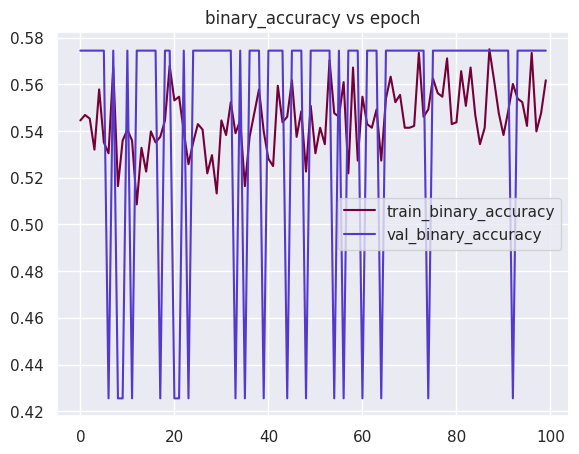

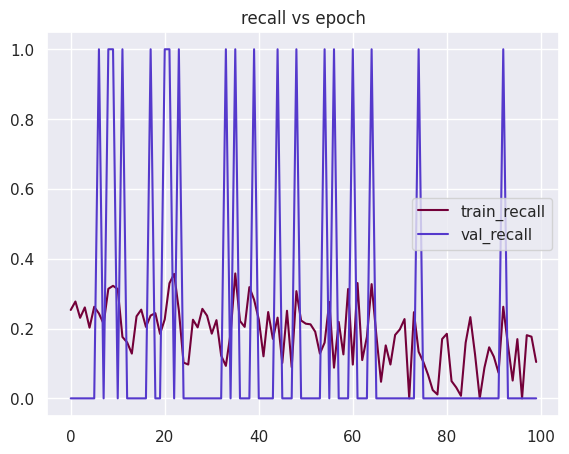

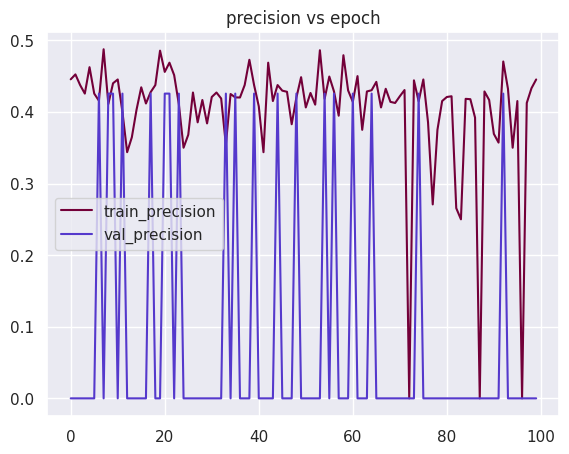

In [20]:
import pickle
from hyperopt import Trials, fmin, tpe
if os.path.exists(TRIALS_FILE_LOCATION):
    trials = pickle.load(open(TRIALS_FILE_LOCATION,'rb'))
else:
    trials = Trials()


evals_done = len(trials.trials)
max_evals = evals_done + 1 #TRIALS_PER_RUN
best = fmin(pistachio_objective,
    space=hp_space,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials)

with open(TRIALS_FILE_LOCATION,'wb') as outfile:
    pickle.dump(trials,outfile)





## SHAP

In [ ]:
import shap
def shap_wrapper(X):
    feature_dict = {k:X[:,i] for i,k in enumerate(feature_columns)}
    return model.predict(feature_dict).flatten()

# shap_n_samples = 50
# shap_explainer_samples = 50

# data_shap = train_df.loc[:,feature_columns]
# explainer = shap.KernelExplainer(shap_wrapper, data_shap.iloc[:shap_explainer_samples,:])
# shap_values = explainer.shap_values(data_shap.iloc[shap_explainer_samples:shap_explainer_samples+shap_n_samples, :], nsamples=200)




In [ ]:
# shap_values.shape

In [ ]:
# shap.plots.scatter(explainer)
# shap.plots.bar(shap_values[0])
# shap_violin_path = os.path.join(plot_dir,'shap_violin.png')
# shap_bar_path = os.path.join(plot_dir,'shap_bar.png')

# shap.summary_plot(
#     shap_values, features=data_shap.iloc[50:100, :], feature_names=feature_columns, plot_type="violin", max_display=30, show=False)
# plt.savefig(shap_violin_path)




In [ ]:
# shap.summary_plot(
#     shap_values, features=data_shap.iloc[50:100, :], feature_names=feature_columns, plot_type="bar", max_display=30, show=False)
# plt.savefig(shap_bar_path)

In [ ]:
# with mlflow.start_run(run_id=run_id) as mlflow_run:
# #     for mm in metrics_to_plot:
# #         # fig_path = os.path.join(plot_dir, f'{mm}_vs_epoch.png');
    

#     mlflow.log_artifact(validation_metrics_path)
#     mlflow.log_artifact(shap_bar_path, artifact_path='evaluation_plots')
#     mlflow.log_artifact(shap_violin_path, artifact_path='evaluation_plots')
    

    


    
    # mlflow.log_metrics(best_stats)